<table align="left" width=100%>
    <tr>
        <td width="10%">
            <img src="title.png">
        </td>
        <td>
            <div align="left">
                <font color="#21618C" size=8px>
                  <b>Fake News Detection-LSTM Classification
                      </b>
                </font>
            </div>
        </td>
    </tr>
</table>

# Problem Statement
Develop a deep learning program to identify when a news source may be producing fake news. We aim to use a corpus of labeled real and fake new articles to build a classifier that can make decisions about information based on the content from the corpus. The model will focus on identifying fake news sources, based on multiple articles originating from a source. Once a source is labeled as a producer of fake news, we can predict with high confidence that any future articles from that source will also be fake news. Focusing on sources widens our article misclassification tolerance, because we will have multiple data points coming from each source.The intended application of the project is for use in applying visibility weights in social media. Using weights produced by this model, social networks can make stories which are highly likely to be fake news less visible.

# Overview
The topic of fake news detection on social media has recently attracted tremendous attention. The basic countermeasure of comparing websites against a list of labeled fake news sources is inflexible, and so a deep learning approach is desirable. Our project aims to use Natural Language Processing to detect fake news directly, based on the text content of news articles.

# Data Definition
**id**: unique id for a news article

**title**: the title of a news article

**author**: author of the news article

**text**: the text of the article; could be incomplete

**label**: a label that marks the article as potentially unreliable

**1**: unreliable
**0**: reliable

# Table of Contents

1. **[Import Libraries](#import_lib)**
2. **[Read Data](#read_data)**
3. **[Data Preprocessing](#data_preprocess)**
    - 3.1 - **[Stopwords Removal](#stop_words)**
4. **[EDA](#EDA)**
5. **[Word Embeddings](#word_emb)**      
6. **[Input Split](#input_split)**
7. **[Split Train and Test](#train_test)**
8. **[Model Building](#model_build)**
9. **[Model Training](#model_train)**
10. **[Result Visualization](#result_viz)**
11. **[Conclusion](#conclusion)**

<a id='import_lib'></a>
# 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import tensorflow as tf
import keras.utils

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a id='read_data'></a>
# 2. Read Data

In [3]:
data=pd.read_csv(r'C:\Users\User\Desktop\Imarticus_capstone_project\fake-news\train.csv')

#displaying the first five rows
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [7]:
data['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [8]:
data['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


<a id='data_preprocess'></a>
# 3. Data Preprocessing

In [4]:
#dropping columns which are not relevant for further processing

data = data.drop(columns=['id', 'title', 'author'], axis=1)

In [5]:
#dropping null values

data=data.dropna(axis=0)

In [5]:
len(data)

20761

In [6]:
#converting all the characters to lower case

data['clean_news']= data['text'].str.lower()
data['clean_news']


0        house dem aide: we didn’t even see comey’s let...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29, ...
3        videos 15 civilians killed in single us airstr...
4        print \nan iranian woman has been sentenced to...
                               ...                        
20795    rapper t. i. unloaded on black celebrities who...
20796    when the green bay packers lost to the washing...
20797    the macy’s of today grew from the union of sev...
20798    nato, russia to hold parallel exercises in bal...
20799      david swanson is an author, activist, journa...
Name: clean_news, Length: 20761, dtype: object

In [7]:
#replacing all the special characters with a space (' ')

data['clean_news']= data['clean_news'].str.replace('[^A-Za-z0-9\s]','')
data['clean_news']= data['clean_news'].str.replace('\n','')
data['clean_news']= data['clean_news'].str.replace('\s+',' ')
data['clean_news']

0        house dem aide we didnt even see comeys letter...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29 2...
3        videos 15 civilians killed in single us airstr...
4        print an iranian woman has been sentenced to s...
                               ...                        
20795    rapper t i unloaded on black celebrities who m...
20796    when the green bay packers lost to the washing...
20797    the macys of today grew from the union of seve...
20798    nato russia to hold parallel exercises in balk...
20799     david swanson is an author activist journalis...
Name: clean_news, Length: 20761, dtype: object

### Since LSTM is a sequence to sequence, it will understand the meaning of the whole context.
### Still we will remove the stopwords before EDA part

<a id='stop_words'></a>
# 3.1. Stopwords Removal

In [8]:
#removing stopwords

from nltk.corpus import stopwords
stop= stopwords.words('english')
data['clean_news']= data['clean_news'].apply(lambda x:" ".join([word for word in x.split() if word not in stop]))
data.head()

,text,label,clean_news
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide didnt even see comeys letter ja...
1,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october 29 2016 tension ...
3,Videos 15 Civilians Killed In Single US Airstr...,1,videos 15 civilians killed single us airstrike...
4,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...


<a id='EDA'></a>
# 4. EDA


<AxesSubplot:>

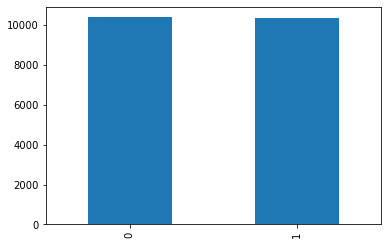

In [28]:
data['label'].value_counts().plot(kind = 'bar')

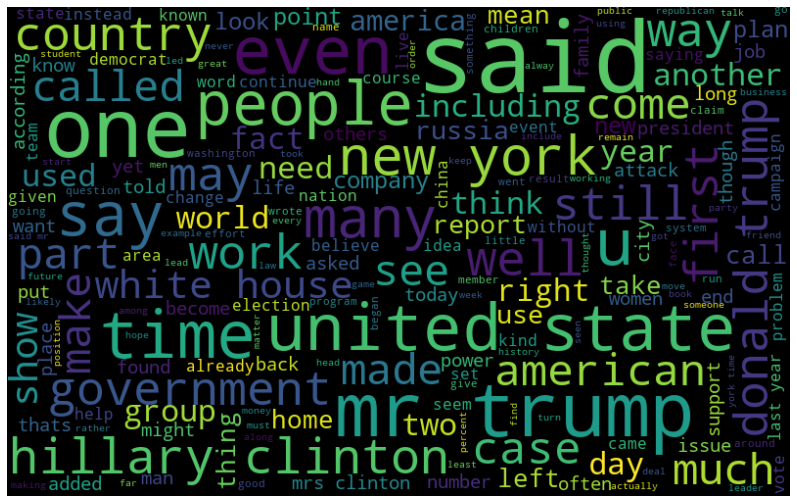

In [10]:
#visualizing the frequently occuring words in the article

frequent_words= " ".join([sentence for sentence in data['clean_news']])

wordcloud= WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(frequent_words)

#plotting the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


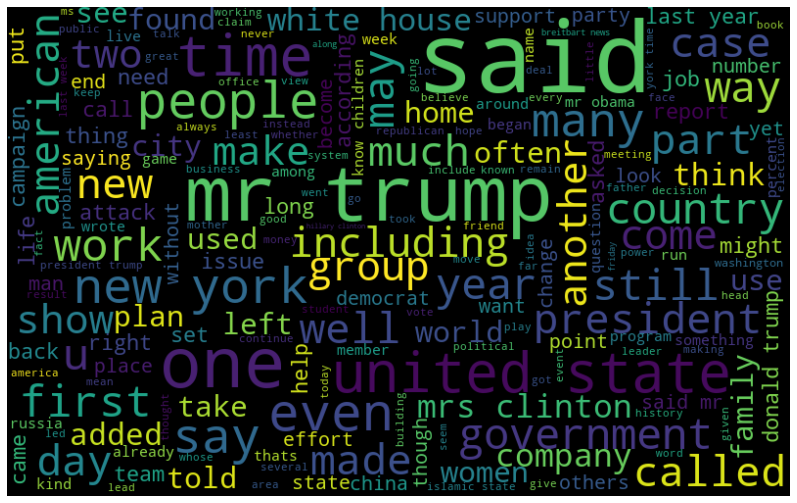

In [29]:
#visualizing the frequent words for real news(0)

frequent_words0= " ".join([sentence for sentence in data['clean_news'][data['label']==0]])

wordcloud= WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(frequent_words0)

#plotting the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


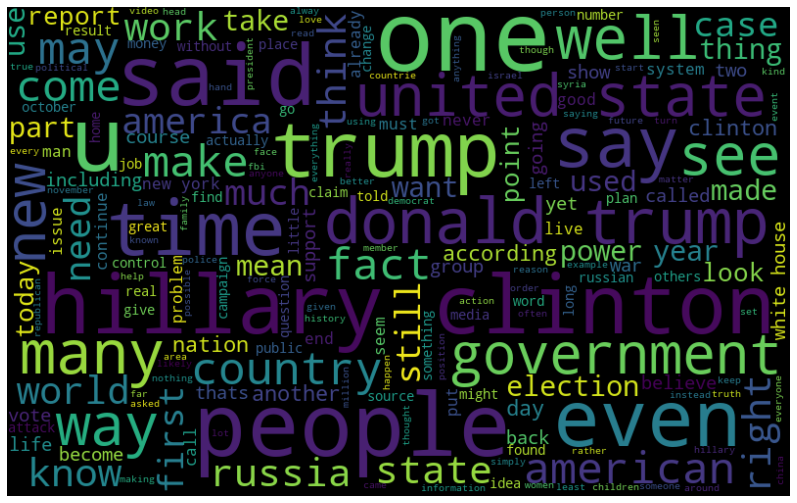

In [30]:
#visualizing the frequent words for fake news(1)

frequent_words1= " ".join([sentence for sentence in data['clean_news'][data['label']==1]])

wordcloud= WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(frequent_words1)

#plotting the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


<a id='word_emb'></a>
# 5. Word Embeddings

In [9]:
#Tokenization of the text and padding of the sequence with the help of word embedding model
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

#tokenizing the text

tokenizer= Tokenizer()
tokenizer.fit_on_texts(data['clean_news'])
word_index= tokenizer.word_index
vocab_size= len(word_index)
vocab_size

199536

In [10]:
#padding

sequences= tokenizer.texts_to_sequences(data['clean_news'])
padded_sequences= pad_sequences(sequences, maxlen=700, padding='post', truncating='post')


In [11]:
#Creating embedding matrix

embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [12]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
embedding_matrix[1]

array([-0.13128   , -0.45199999,  0.043399  , -0.99798   , -0.21053   ,
       -0.95867997, -0.24608999,  0.48413   ,  0.18178   ,  0.47499999,
       -0.22305   ,  0.30063999,  0.43496001, -0.36050001,  0.20245001,
       -0.52594   , -0.34707999,  0.0075873 , -1.04970002,  0.18673   ,
        0.57369   ,  0.43814   ,  0.098659  ,  0.38769999, -0.22579999,
        0.41911   ,  0.043602  , -0.73519999, -0.53583002,  0.19276001,
       -0.21961001,  0.42515001, -0.19081999,  0.47187001,  0.18826   ,
        0.13357   ,  0.41839001,  1.31379998,  0.35677999, -0.32172   ,
       -1.22570002, -0.26635   ,  0.36715999, -0.27586001, -0.53245997,
        0.16786   , -0.11253   , -0.99958998, -0.60706002, -0.89270997,
        0.65156001, -0.88783997,  0.049233  ,  0.67110997, -0.27553001,
       -2.40050006, -0.36989   ,  0.29135999,  1.34979999,  1.73529994,
        0.27000001,  0.021299  ,  0.14421999,  0.023784  ,  0.33643001,
       -0.35475999,  1.09210002,  1.48450005,  0.49430001,  0.15

<a id='input_split'></a>
# 6. Input Split

In [15]:
padded_sequences[1]

array([   258,     28,   1557,     92,   4913,  27340,    415,   2246,
         2067,    377,    532,   1558,   5339,     29,     12,    796,
          179,    361,   1917,  17459,    829,  20147,   2990,   2626,
          640,    747,    252,   2025,   3113,  10995,    125,     39,
         2086,  78618,   3022,   3646,   3561,   3113,    835,    153,
         3458,     29,   9775,  51963,   3724,     18,    218,     20,
         3234,  20147,  10024,    625,     11,    481,   2494,   2417,
         8173,    442,    701,    613,    147,     14,  22280,    902,
          324,      8,    164,   3712,     60,  11541,    867,   2644,
           16,    864,   4422,    176,   5305,   2086,   4253,     40,
          257,    835,    192,     10,   2403,     10,   2086,   9775,
           58,   8372,  11246, 104297,  20952,   3713,  20953,  78619,
       104298,   5459,  31169,  25044,   7998,  19120,  65806,   4403,
          168,    261,  25045,   4403,    162,    355,    904,   1581,
      

<a id='train_test'></a>
# 7. Split Train and Test

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, data['label'], test_size=0.20, random_state=42, stratify=data['label'])

<a id='model_build'></a>
# 8. Model Building

In [44]:
from keras.layers import LSTM, Dropout, Dense, Embedding
from keras import Sequential


# model = Sequential([
#     Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
#     Dropout(0.2),
#     LSTM(128, return_sequences=True),
#     LSTM(128),
#     Dropout(0.2),
#     Dense(512),
#     Dropout(0.2),
#     Dense(256),
#     Dense(1, activation='sigmoid')
# ])

model = Sequential([Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(256),
    Dense(1, activation='sigmoid')])

In [45]:
from tensorflow import keras

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         19953700  
                                                                 
 dropout_4 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20,104,229
Trainable params: 150,529
Non

<a id='model_train'></a>
# 9. Model Training

In [33]:
# train the model

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
519/519 [==============================] - 584s 1s/step - loss: 0.6620 - accuracy: 0.5868 - val_loss: 0.6012 - val_accuracy: 0.7065
Epoch 2/10
519/519 [==============================] - 531s 1s/step - loss: 0.6243 - accuracy: 0.6133 - val_loss: 0.4234 - val_accuracy: 0.8245
Epoch 3/10
519/519 [==============================] - 525s 1s/step - loss: 0.2979 - accuracy: 0.8834 - val_loss: 0.2178 - val_accuracy: 0.9133
Epoch 4/10
519/519 [==============================] - 526s 1s/step - loss: 0.1881 - accuracy: 0.9274 - val_loss: 0.1632 - val_accuracy: 0.9345
Epoch 5/10
519/519 [==============================] - 522s 1s/step - loss: 0.1591 - accuracy: 0.9389 - val_loss: 0.1356 - val_accuracy: 0.9492
Epoch 6/10
519/519 [==============================] - 526s 1s/step - loss: 0.1341 - accuracy: 0.9503 - val_loss: 0.1249 - val_accuracy: 0.9509
Epoch 7/10
519/519 [==============================] - 522s 1s/step - loss: 0.1106 - accuracy: 0.9598 - val_loss: 0.1113 - val_accuracy: 0.9588

<a id='Result_viz'></a>
# 10. Result Visualization

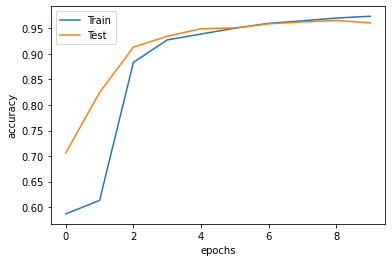

In [34]:
# visualize the results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

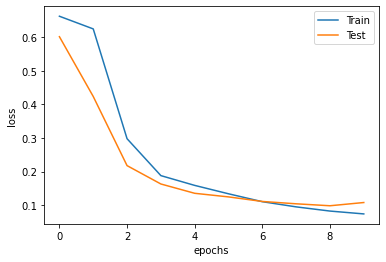

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'])
plt.show()

In [36]:
#printing final vlaues

print(history.history['accuracy'][-1])
print(history.history['val_accuracy'][-1])

0.9736873507499695
0.9607512354850769


# The model has achieved accuracy of 97% which is excellent. 

In [37]:
y_pred = model.predict(x_test).argmax(axis =-1)

In [42]:
pred = ['Real' if x == 0 else 'Fake' for x in y_pred]

In [49]:
pred

['Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 'Real',
 

<a id='conclusion'></a>
# 11. Conclusion
The task of classifying news manually requires in-depth knowledge of the domain and expertise to identify anomalies in the text. In this research, we discussed the problem of classifying fake news articles using deep learning model. The primary aim of the research is to identify patterns in text that differentiate fake articles from true news. We extracted different textual features from the articles using an LIWC tool and used the feature set as an input to the models. The learning models were trained and parameter-tuned to obtain optimal accuracy. Some models have achieved comparatively higher accuracy than others. We used multiple performance metrics to compare the results for each algorithm. The ensemble learners have shown an overall better score on all performance metrics as compared to the individual learners.

Fake news detection has many open issues that require attention of researchers. For instance, in order to reduce the spread of fake news, identifying key elements involved in the spread of news is an important step. Graph theory and machine learning techniques can be employed to identify the key sources involved in spread of fake news. Likewise, real time fake news identification in videos can be another possible future direction.